In [1]:
import numpy as np
import pandas as pd

import dask.dataframe as dd
import dask.array as da
import dask.bag as db

index = pd.date_range("2021-09-01", periods=2400, freq="1h")
df = pd.DataFrame({"a": np.arange(2400), "b": list("abcaddbe" * 300)}, index=index)
ddf = dd.from_pandas(df, npartitions=10)
print(ddf)

Dask DataFrame Structure:
                         a       b
npartitions=10                    
2021-09-01 00:00:00  int64  string
2021-09-11 00:00:00    ...     ...
...                    ...     ...
2021-11-30 00:00:00    ...     ...
2021-12-09 23:00:00    ...     ...
Dask Name: frompandas, 1 expression
Expr=df


In [2]:
ddf.divisions

(Timestamp('2021-09-01 00:00:00'),
 Timestamp('2021-09-11 00:00:00'),
 Timestamp('2021-09-21 00:00:00'),
 Timestamp('2021-10-01 00:00:00'),
 Timestamp('2021-10-11 00:00:00'),
 Timestamp('2021-10-21 00:00:00'),
 Timestamp('2021-10-31 00:00:00'),
 Timestamp('2021-11-10 00:00:00'),
 Timestamp('2021-11-20 00:00:00'),
 Timestamp('2021-11-30 00:00:00'),
 Timestamp('2021-12-09 23:00:00'))

In [3]:
print(ddf.partitions[1])

Dask DataFrame Structure:
                   a       b
npartitions=1               
2021-09-11     int64  string
2021-09-21       ...     ...
Dask Name: partitions, 2 expressions
Expr=Partitions(frame=df, partitions=[1])


In [4]:
ddf["2021-10-01": "2021-10-09 5:00"].compute()

,a,b
2021-10-01 00:00:00,720,a
2021-10-01 01:00:00,721,b
2021-10-01 02:00:00,722,c
2021-10-01 03:00:00,723,a
2021-10-01 04:00:00,724,d
...,...,...
2021-10-09 01:00:00,913,b
2021-10-09 02:00:00,914,c
2021-10-09 03:00:00,915,a
2021-10-09 04:00:00,916,d


In [5]:
ddf.a.mean()

<dask_expr.expr.Scalar: expr=df['a'].mean(), dtype=float64>

In [6]:
print(ddf.a.mean().compute())

1199.5


In [7]:
ddf.b.unique()

Dask Series Structure:
npartitions=10
    string
       ...
     ...  
       ...
       ...
Dask Name: unique, 3 expressions
Expr=Unique(frame=df['b'])

In [8]:
ddf.b.unique().compute()

0    e
0    c
1    d
0    a
0    b
Name: b, dtype: string

In [9]:
result = ddf["2021-10-01": "2021-10-09 5:00"].a.cumsum() - 100
result

Dask Series Structure:
npartitions=1
2021-10-01 00:00:00.000000000    int64
2021-10-09 05:00:59.999999999      ...
Dask Name: sub, 5 expressions
Expr=CumSum(frame=(LocSlice(frame=df, iindexer=slice(Timestamp('2021-10-01 00:00:00'), Timestamp('2021-10-09 05:00:59.999999999'), None)))['a'], skipna=True) - 100

In [10]:
print(result)

Dask Series Structure:
npartitions=1
2021-10-01 00:00:00.000000000    int64
2021-10-09 05:00:59.999999999      ...
Dask Name: sub, 5 expressions
Expr=CumSum(frame=(LocSlice(frame=df, iindexer=slice(Timestamp('2021-10-01 00:00:00'), Timestamp('2021-10-09 05:00:59.999999999'), None)))['a'], skipna=True) - 100


In [11]:
result.dask

{('sub-eebc03bb5505dfb07416b4fbd92d5139',
  0): <Task ('sub-eebc03bb5505dfb07416b4fbd92d5139', 0) sub(...)>,
 ('cumulativefinalize-c84b0f8ecf10f71d230544539f044652',
  0): ('cumsum-e20fcbf6c4d8eda775020e3b7c4b791d', 0),
 ('operation-aacd21d2599cdd1704dfcf208f8222e1',
  0): <Task ('operation-aacd21d2599cdd1704dfcf208f8222e1', 0) operation(...)>,
 ('cumsum-e20fcbf6c4d8eda775020e3b7c4b791d',
  0): <Task ('cumsum-e20fcbf6c4d8eda775020e3b7c4b791d', 0) cumsum(...)>,
 ('getitem-b30cd0817323990ef9ce62e05e218713',
  0): <Task ('getitem-b30cd0817323990ef9ce62e05e218713', 0) getitem(...)>,
 ('loc-efb1c1846e6ebd78444b69ffc82fcb86',
  0): <Task ('loc-efb1c1846e6ebd78444b69ffc82fcb86', 0) loc(...)>,
 ('partitions-16166c71926eb3bb0e9da95b33a1c035',
  0): Alias(('partitions-16166c71926eb3bb0e9da95b33a1c035', 0)->('frompandas-33946d5e46faffe611c6bc08f15bacda', 3)),
 ('frompandas-33946d5e46faffe611c6bc08f15bacda',
  0): DataNode(                       a  b
 2021-09-01 00:00:00    0  a
 2021-09-01 01:00:

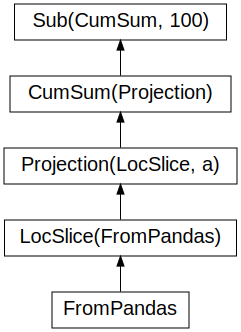

In [12]:
result.visualize()

In [14]:
import dask

@dask.delayed
def inc(x):
   return x + 1

@dask.delayed
def add(x, y):
   return x + y

a = inc(1)       # no work has happened yet
b = inc(2)       # no work has happened yet
c = add(a, b)    # no work has happened yet

c = c.compute()  # This triggers all of the above computations
c

5

In [16]:
from dask.distributed import Client

client = Client()

def inc(x):
   return x + 1

def add(x, y):
   return x + y

a = client.submit(inc, 1)     # work starts immediately
b = client.submit(inc, 2)     # work starts immediately
c = client.submit(add, a, b)  # work starts immediately

c = c.result()                # block until work finishes, then gather result
c

/home/carlos/PycharmProjects/cbnetwork/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40979 instead
  warnings.warn(


5

In [17]:
from dask.distributed import Client

client = Client()
client

/home/carlos/PycharmProjects/cbnetwork/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38693 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38693/status,
Dashboard: http://127.0.0.1:38693/status,Workers: 4
Total threads: 4,Total memory: 7.69 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37459,Workers: 4
Dashboard: http://127.0.0.1:38693/status,Total threads: 4
Started: Just now,Total memory: 7.69 GiB
Comm: tcp://127.0.0.1:46029,Total threads: 1
Dashboard: http://127.0.0.1:45525/status,Memory: 1.92 GiB
Nanny: tcp://127.0.0.1:40789,


In [18]:
client.dashboard_link

'http://127.0.0.1:38693/status'

In [1]:
from dask.distributed import Client

client = Client(n_workers=2, threads_per_worker=2, memory_limit="1GB")
client

/home/carlos/PycharmProjects/cbnetwork/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43315 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43315/status,
Dashboard: http://127.0.0.1:43315/status,Workers: 2
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40507,Workers: 2
Dashboard: http://127.0.0.1:43315/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: tcp://127.0.0.1:39985,Total threads: 2
Dashboard: http://127.0.0.1:38899/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:35863,


In [5]:
import dask
df = dask.datasets.timeseries()

In [7]:
df.dtypes

name    string[pyarrow]
id                int64
x               float64
y               float64
dtype: object